In [1]:
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

In [3]:
#import os
#os.chdir("/content/drive")

In [4]:
#cd My Drive

In [5]:
#cd CS230-master

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [7]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model3 import train_generator

Using TensorFlow backend.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout,Activation, Lambda
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import  MaxPooling1D, MaxPooling2D,Reshape, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from scipy.stats import linregress
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.backend import transpose, permute_dimensions,squeeze
from keras.optimizers import Adam

In [9]:
# PARAMETERS AND COMMENTs
#
# Conv2D with 10bar target and 0-5.6-7 training/val 
# standardize window = false
# Dropout back to 50; epochs back to 60
# Try l2 reg on dense layer with small batch size - 50
configs={}
configs['batch_size']=50

configs['sequence_length']=100
configs['epochs']=100
configs['learning_rate']=.001
configs['learning_rate_decay']=0
configs['opt']=Adam(lr=configs['learning_rate'],
                   decay=configs['learning_rate_decay'])
configs['save_dir']='saved_models'
configs['nflag']=True #standardize each window



traindays=[0,1,2,3,4,5,6,7] #training and val days to look at in dataset
valdays=[8,9]
colx=range(40)# columns to look at in dataset - 0-40 are LOB
#colx=np.concatenate([np.arange(20),86+np.arange(20)])
coly=148 # target 144-148 are 1,2,3,5,10
generate_files=True
print('trainday',traindays,'valdays',valdays,'colx',colx,'coly',coly)
print(configs)

trainday [0, 1, 2, 3, 4, 5, 6, 7] valdays [8, 9] colx range(0, 40) coly 148
{'batch_size': 50, 'sequence_length': 100, 'epochs': 100, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'opt': <keras.optimizers.Adam object at 0x7f373574b400>, 'save_dir': 'saved_models', 'nflag': True}


### Generate data from zip files or retrieve from pkl files in directory

In [10]:
if generate_files==True:
  path='data/'
  d=DataLoader(path)
  traindf=d.get_days(traindays)
  trainoffset=d.get_stock_offset(traindays)
  valdf=d.get_days(valdays)
  valoffset=d.get_stock_offset(valdays)

  traindf.to_pickle("traindf.pkl")
  valdf.to_pickle("valdf.pkl")
  np.save("trainoffset",trainoffset)
  np.save("valoffset",valoffset)

else:
  traindf=pd.read_pickle('traindf.pkl')
  valdf=pd.read_pickle('valdf.pkl')
  trainoffset=np.load("trainoffset.npy")
  valoffset=np.load("valoffset.npy")

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,colx].values
trainy=to_categorical(traindf.iloc[:,coly].values-1)
valx=valdf.iloc[:,colx].values
valy=to_categorical(valdf.iloc[:,coly].values-1)



### Build and compile model

In [11]:
model = Sequential()
model.add(Conv1D(16, kernel_size=2, strides=1,activation='relu',padding='causal',input_shape=(100,40)))    
            
model.add(Conv1D(16,kernel_size=2,dilation_rate=2,activation='relu',padding='causal'))
model.add(Conv1D(16,kernel_size=2,dilation_rate=4,activation='relu',padding='causal'))
model.add(Conv1D(16,kernel_size=2,dilation_rate=8,activation='relu',padding='causal'))
model.add(Conv1D(16,kernel_size=2,dilation_rate=16,activation='relu',padding='causal'))
model.add(Flatten())        
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.40))
model.add(Dense(3, activation='softmax'))
#
opt=Adam(lr=configs['learning_rate'],decay=configs['learning_rate_decay'])
model.compile(loss="categorical_crossentropy", optimizer=configs['opt'],metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 16)           1296      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 16)           528       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 16)           528       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 16)           528       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 16)           528       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                102464    
__________

### Model Fitting

In [12]:
training_generator=GenerateBatch(trainx,trainy,trainoffset)
val_generator=GenerateBatch(valx,valy,valoffset)

In [13]:
# out-of memory generative training
steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

In [14]:
# GenerateBatch2 contains logic to avoid running over stock/day divides
history=train_generator(
    model=model,
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
    epochs=configs['epochs'],
    batch_size=configs['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['save_dir']
    )

    

[Model] Training Started
[Model] 100 epochs, 50 batch size, 6146.0 batches per epoch
Epoch 1/100
 - 64s - loss: 1.0555 - acc: 0.4012 - val_loss: 1.1048 - val_acc: 0.3176
Epoch 2/100
 - 60s - loss: 1.0512 - acc: 0.4035 - val_loss: 1.1058 - val_acc: 0.3465
Epoch 3/100
 - 60s - loss: 1.0510 - acc: 0.4012 - val_loss: 1.1141 - val_acc: 0.3120
Epoch 4/100
 - 60s - loss: 1.0485 - acc: 0.4062 - val_loss: 1.1192 - val_acc: 0.3487
Epoch 5/100
 - 60s - loss: 1.0501 - acc: 0.4038 - val_loss: 1.1092 - val_acc: 0.3178
Epoch 6/100
 - 60s - loss: 1.0500 - acc: 0.4052 - val_loss: 1.1045 - val_acc: 0.3541
Epoch 7/100
 - 60s - loss: 1.0496 - acc: 0.4065 - val_loss: 1.1032 - val_acc: 0.3491
Epoch 8/100
 - 60s - loss: 1.0494 - acc: 0.4059 - val_loss: 1.1160 - val_acc: 0.3492
Epoch 9/100
 - 61s - loss: 1.0496 - acc: 0.4078 - val_loss: 1.1080 - val_acc: 0.3110
Epoch 10/100
 - 60s - loss: 1.0496 - acc: 0.4054 - val_loss: 1.1058 - val_acc: 0.3349
Epoch 11/100
 - 61s - loss: 1.0485 - acc: 0.4078 - val_loss: 1.1

Epoch 96/100
 - 60s - loss: 0.4195 - acc: 0.8530 - val_loss: 0.3469 - val_acc: 0.8861
Epoch 97/100
 - 61s - loss: 0.4187 - acc: 0.8545 - val_loss: 0.3505 - val_acc: 0.8875
Epoch 98/100
 - 61s - loss: 0.4172 - acc: 0.8546 - val_loss: 0.3808 - val_acc: 0.8742
Epoch 99/100
 - 61s - loss: 0.4169 - acc: 0.8547 - val_loss: 0.3551 - val_acc: 0.8845
Epoch 100/100
 - 61s - loss: 0.4160 - acc: 0.8550 - val_loss: 0.3405 - val_acc: 0.8906
[Model] Training Completed. Model saved as saved_models/08122018-035259-e100.h5
Time taken: 1:41:11.091597


In [15]:
#from keras.models import load_model
#model = load_model('saved_models/04122018-125307-e20.h5')

Text(0,0.5,'Cost')

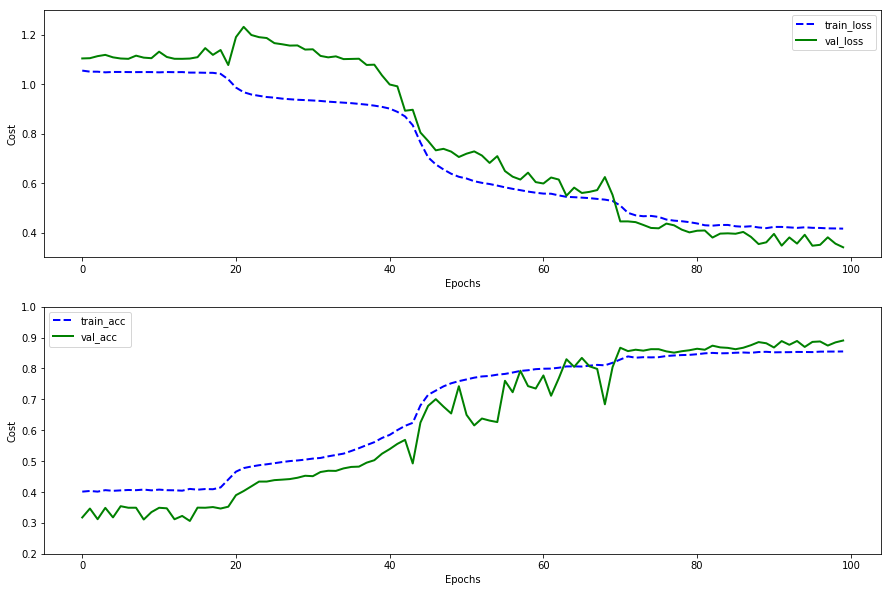

In [37]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.3,1.3])
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.subplot(2,1,2)
plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
plt.legend()
plt.ylim([.2,1])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [17]:
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
val_gen=val_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])

In [18]:
y_train=[]
yhat_train=[]
y_val=[]
yhat_val=[]

In [19]:
# predict using same sequence lengths and batches as in training
for i in range(int(steps_per_epoch)):
    dat=next(train_gen)
    y_train.append(dat[1])
    yhat_train.append(model.predict(dat[0]))
for i in range(int(steps_per_epoch_val)):
    dat=next(val_gen)
    y_val.append(dat[1])
    yhat_val.append(model.predict(dat[0]))
                                            

In [20]:
burn_in=0 # drop early predictions 
y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


### Training and Validation Performance

In [21]:
# How well have we done on training data
print ("Training ")
Y=np.argmax(y_train,axis=1)
Yhat=np.argmax(yhat_train,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
#print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score: %.2f" %cohen_kappa_score(Yhat,Y))
# How well have we done on test data
print("Test ")
Y=np.argmax(y_val,axis=1)
Yhat=np.argmax(yhat_val,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
#print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score: %.2f" % cohen_kappa_score(Yhat,Y))

Training 
             precision    recall  f1-score   support

          0       0.88      0.94      0.91    113364
          1       0.89      0.77      0.82     80932
          2       0.90      0.93      0.91    111972

avg / total       0.89      0.89      0.89    306268

cohen kappa score: 0.83
Test 
             precision    recall  f1-score   support

          0       0.87      0.94      0.90     99256
          1       0.92      0.82      0.87    109248
          2       0.88      0.92      0.90     97969

avg / total       0.89      0.89      0.89    306473

cohen kappa score: 0.84


### Visualize Filters using Gradient Ascent

In [22]:
import keras.backend as K

In [23]:
layer_dict=dict([(layer.name,layer) for layer in model.layers[1::]])
input_img=model.input

In [24]:
def normalize(x):
     return x/(K.sqrt(K.mean(K.square(x)))+K.epsilon())

In [61]:
layer_name='conv1d_5'
n=16

In [62]:
kept_filters=[]
for filter_index in range(n):
    layer_output=layer_dict[layer_name].output
    loss=K.mean(layer_output[:,filter_index:,:])
    grads=K.gradients(loss,input_img)[0]
    grads=normalize(grads)
    iterate=K.function([input_img],[loss,grads])
    step=1
    input_img_data=np.random.random((1,100,40))
    for i in range(40):
        loss_value,grad_values=iterate([input_img_data])
        input_img_data +=grad_values*step
    print('Filter: %d, Final loss value:%.2f' % (filter_index,loss_value))
    if loss_value >0:
        kept_filters.append((input_img_data[0],loss_value))
print(len(kept_filters))

Filter: 0, Final loss value:4398.64
Filter: 1, Final loss value:5685.73
Filter: 2, Final loss value:5537.69
Filter: 3, Final loss value:5286.34
Filter: 4, Final loss value:4286.30
Filter: 5, Final loss value:4394.50
Filter: 6, Final loss value:4973.29
Filter: 7, Final loss value:5364.76
Filter: 8, Final loss value:5327.71
Filter: 9, Final loss value:4459.91
Filter: 10, Final loss value:4367.83
Filter: 11, Final loss value:5730.37
Filter: 12, Final loss value:4948.95
Filter: 13, Final loss value:5238.62
Filter: 14, Final loss value:5699.69
Filter: 15, Final loss value:5463.72
16


In [63]:
layer_dict.keys()

dict_keys(['conv1d_2', 'conv1d_3', 'conv1d_4', 'conv1d_5', 'flatten_1', 'dense_1', 'dropout_1', 'dense_2'])

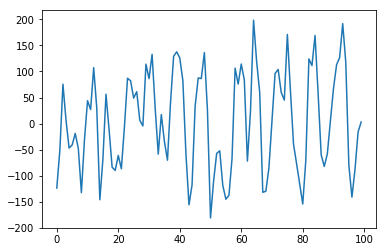

In [64]:
img=kept_filters[0][0]
plt.plot(img[:,0])



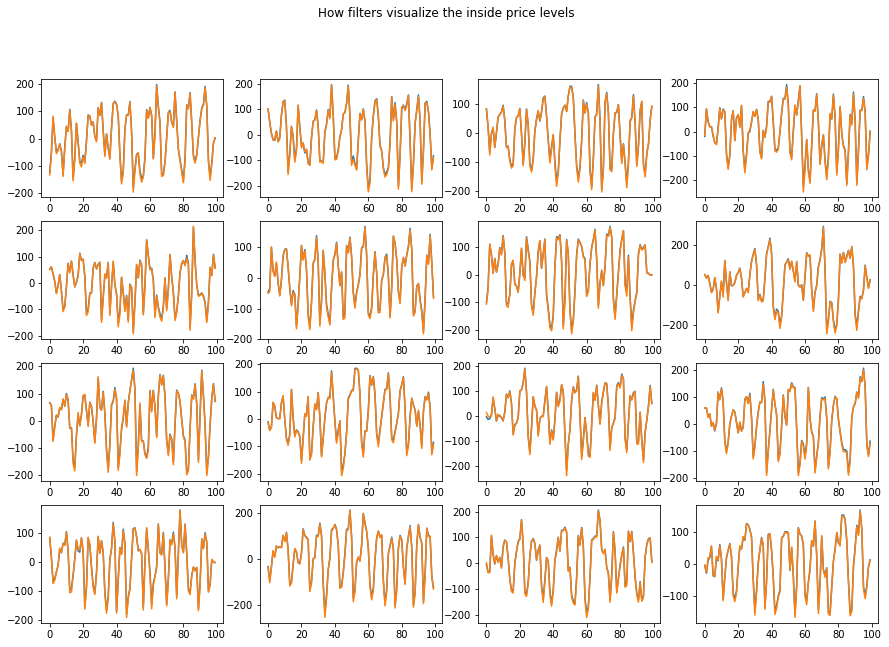

In [65]:
plt.figure(figsize=(15,10))
plt.suptitle("How filters visualize the inside price levels",fontsize=12)
for i,f in enumerate(kept_filters[:16]):
    img=f[0]
    plt.subplot(4,4,i+1)
    plt.plot(img[:,[0,2]])


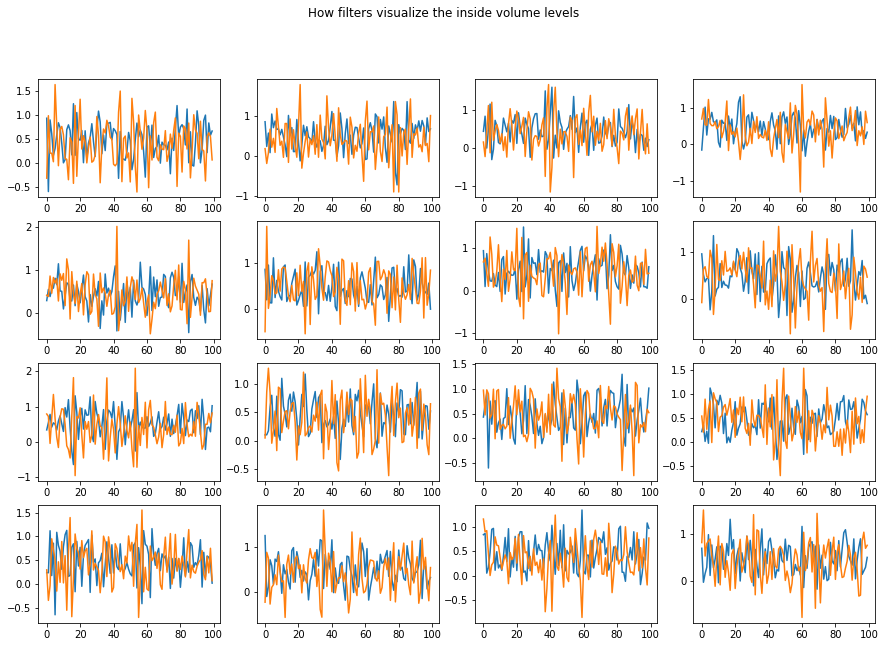

In [66]:
plt.figure(figsize=(15,10))
plt.suptitle("How filters visualize the inside volume levels",fontsize=12)
for i,f in enumerate(kept_filters[:16]):
    img=f[0]
    plt.subplot(4,4,i+1)
    plt.plot(img[:,[1,3]])

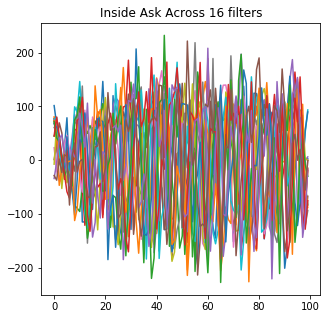

In [30]:
# visualize one layer across all 16 filters
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(figsize=(5,5))
plt.title("Inside Ask Across 16 filters")
for f in kept_filters[:16]:
    img=f[0]
    plt.plot(img[range(0,100)][:,0])

###  Find highest predictions for each category in each batch. Plot highest values

In [31]:
dn, sm, up = [],[],[]

# find the highest scoring input for each categorical output category in each batch
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
for i in range(int(steps_per_epoch)):
    dat=next(train_gen)[0]
    yhat=model.predict(dat)
    #
    dn.append(dat[np.argmax(yhat[:,2])])
    sm.append(dat[np.argmax(yhat[:,1])])
    up.append(dat[np.argmax(yhat[:,0])])
   

In [32]:
dnavg=np.average(np.array(dn),axis=0)
upavg=np.average(np.array(up),axis=0)

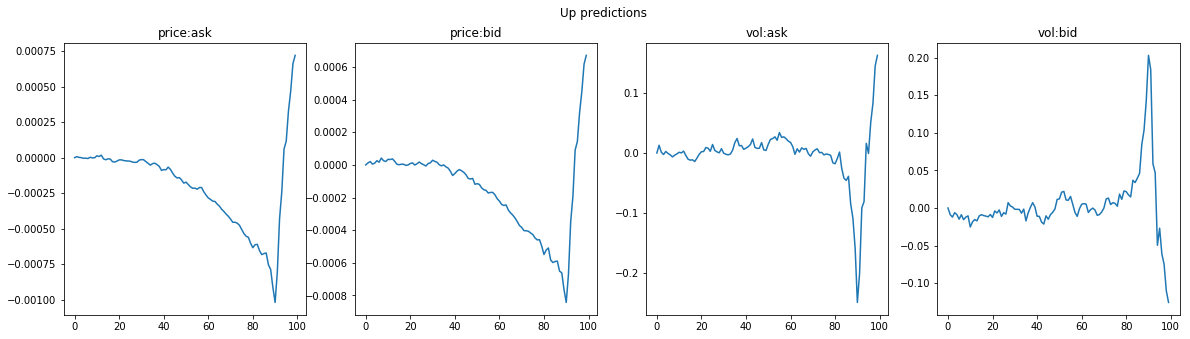

In [33]:
t=np.array([0])
plt.figure(figsize=(20,5))
plt.suptitle("Up predictions")
plt.subplot(1,4,1)
_=plt.plot(upavg[:,t])
plt.title('price:ask')
plt.subplot(1,4,2)
_=plt.plot(upavg[:,t+2])
plt.title('price:bid')
plt.subplot(1,4,3)
_=plt.plot(upavg[:, t+1])
plt.title('vol:ask')
plt.subplot(1,4,4)
_=plt.plot(upavg[:,t+3])
_=plt.title('vol:bid')

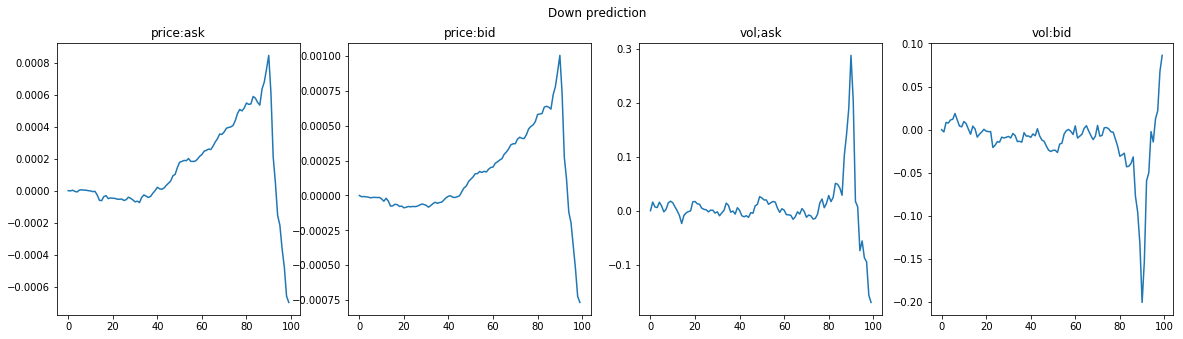

In [34]:
plt.figure(figsize=(20,5))
plt.suptitle("Down prediction")
plt.subplot(1,4,1)
_=plt.plot(dnavg[:,t])
plt.title('price:ask')
plt.subplot(1,4,2)
_=plt.plot(dnavg[:,t+2])
plt.title('price:bid')
plt.subplot(1,4,3)
_=plt.plot(dnavg[:, t+1])
plt.title('vol;ask')
plt.subplot(1,4,4)
_=plt.plot(dnavg[:,t+3])
_=plt.title('vol:bid')

### Perform Gradient Ascent on each category (final softmax layer) to generate input with strongest signal.

In [35]:
#visualize
ylabel=[]
layer_name='dense_2' #final layer - categorical
layer_output=layer_dict[layer_name].output
print(layer_output.shape)
for i in range(3):
    print('processing label %d' % i)
    loss=layer_output[:,i] #want to increase value of label i
    #loss=K.mean(layer_output[:,filter_index:,:])
    grads=K.gradients(loss,input_img)[0]
    grads=normalize(grads)
    iterate=K.function([input_img],[loss,grads])
    step=1
    input_img_data=np.random.random((1,100,40))
    for j in range(1000):
        loss_value,grad_values=iterate([input_img_data])
        input_img_data +=grad_values*step
        #print('Current loss values:', loss_value)
    print(loss_value)
    ylabel.append((input_img_data[0],loss_value))

(?, 3)
processing label 0
[0.]
processing label 1
[0.]
processing label 2
[0.]


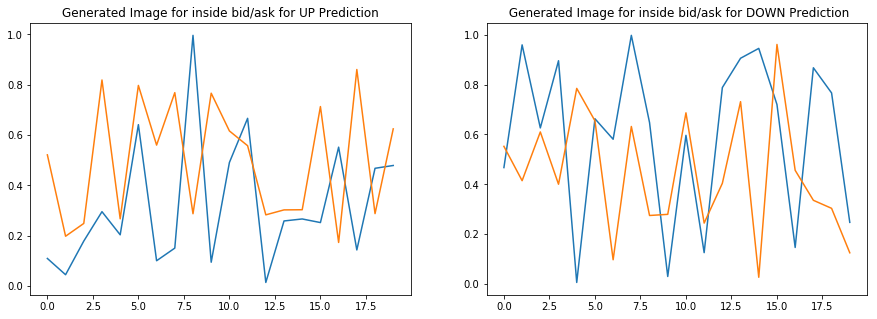

In [71]:

y=ylabel[0][0]

t=np.array([0])
#
y=ylabel[0][0]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Generated Image for inside bid/ask for UP Prediction')
plt.plot(y[range(80,100),t])
plt.plot(y[range(80,100),t+2])
#
y=ylabel[2][0]
plt.subplot(1,2,2)
plt.title(' Generated Image for inside bid/ask for DOWN Prediction')
plt.plot(y[range(80,100),t])
plt.plot(y[range(80,100),t+2])
y=ylabel[0][0]